In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("PySpark").getOrCreate()
spark

In [2]:
import pyspark.sql.functions as F
from pyspark.sql.types import StringType

In [4]:
from RMF_IMplementation_01 import rfm_scores

In [12]:
rfm_scores_df = rfm_scores.toPandas()

<AxesSubplot:xlabel='Monetary', ylabel='Count'>

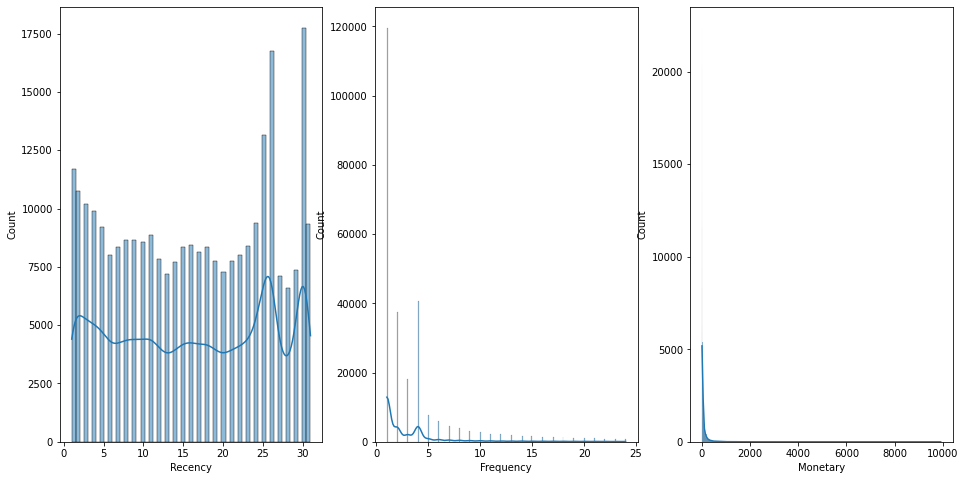

In [13]:
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize=(16, 8))

# Recency distribution plot
sns.histplot(rfm_scores_df['Recency'], kde=True, ax=ax[0])

# Frequency distribution plot
sns.histplot(rfm_scores_df.query('Frequency < 25')['Frequency'], kde=True, ax=ax[1])

# Monetary distribution plot
sns.histplot(rfm_scores_df.query('Monetary < 10000')['Monetary'], kde=True, ax=ax[2])

In [14]:
# We are going to divide our customer base into 3 segments: 
#    1st segment: top 20%
#    2nd segment: 20% - 60%
#    3rd segment: bottom 40%

# Understand and calculate different quantiles

rfm_scores.toPandas()["Recency"].describe()



count    285460.000000
mean         16.314608
std           9.410550
min           1.000000
25%           8.000000
50%          17.000000
75%          25.000000
max          31.000000
Name: Recency, dtype: float64

In [15]:
segments = [0.33, 0.66]

quantiles = rfm_scores.approxQuantile(
    ["Recency", "Frequency", "Monetary"], 
    segments,
    0)
quantiles

[[11.0, 22.0], [1.0, 4.0], [9.37, 37.48]]

In [16]:
# Calculate R,F,M scores considering 3 quantiles

rfm_scores = (rfm_scores
    .withColumn("R_Score",
                F.when(F.col("Recency") < quantiles[0][0], F.lit(1))
                 .when(F.col("Recency") < quantiles[0][1], F.lit(2))
                 .otherwise(F.lit(3)))
    .withColumn("F_Score",
                F.when(F.col("Frequency") < quantiles[1][0], F.lit(3))
                 .when(F.col("Frequency") < quantiles[1][1], F.lit(2))
                 .otherwise(F.lit(1)))
    .withColumn("M_Score",
                F.when(F.col("Monetary") < quantiles[2][0], F.lit(3))
                 .when(F.col("Monetary") < quantiles[2][1], F.lit(2))
                 .otherwise(F.lit(1))))


In [17]:

rfm_agg_scores = (
    rfm_scores
    .withColumn("RFM_Score", F.col("R_Score") + F.col("F_Score") + F.col("M_Score"))
    .withColumn("RFM_ScoreGroup", F.concat(F.col("R_Score").cast(StringType()), F.col("F_Score").cast(StringType()), F.col("M_Score").cast(StringType())))
)

rfm_agg_scores.show()

+--------+-------+---------+------------------+-------+-------+-------+---------+--------------+
| user_id|Recency|Frequency|          Monetary|R_Score|F_Score|M_Score|RFM_Score|RFM_ScoreGroup|
+--------+-------+---------+------------------+-------+-------+-------+---------+--------------+
| 4103071|     11|        5|             16.57|      2|      1|      2|        5|           212|
| 8846226|     30|       32|            140.19|      3|      1|      1|        5|           311|
| 9794320|      9|       19|16.359999999999996|      1|      1|      2|        4|           112|
|10280338|      5|       79| 418.7999999999998|      1|      1|      1|        3|           111|
|12055855|     16|        2|              6.46|      2|      2|      3|        7|           223|
|13383118|     20|        1|              8.89|      2|      2|      3|        7|           223|
|13392135|      5|        2|              9.83|      1|      2|      2|        5|           122|
|14297993|     10|       11|14

In [18]:
# Identify the three segments again based on RFMScore (33% in each segment)
segments = [0.33, 0.66]
quantiles = rfm_agg_scores.approxQuantile("RFM_Score", segments, 0)
quantiles

[5.0, 6.0]

In [19]:
# Assign loyalty level to each customer
loyalty_level = ['Platinum', 'Gold', 'Silver']

rfm_loyalty = (rfm_agg_scores
    .withColumn("Loyalty",
                F.when((F.col("RFM_Score") <= quantiles[0]), F.lit(loyalty_level[0]))
                 .when((F.col("RFM_Score") <= quantiles[1]), F.lit(loyalty_level[1]))
                 .otherwise(F.lit(loyalty_level[2]))))

In [20]:
rfm_loyalty.show()


+--------+-------+---------+------------------+-------+-------+-------+---------+--------------+--------+
| user_id|Recency|Frequency|          Monetary|R_Score|F_Score|M_Score|RFM_Score|RFM_ScoreGroup| Loyalty|
+--------+-------+---------+------------------+-------+-------+-------+---------+--------------+--------+
| 4103071|     11|        5|             16.57|      2|      1|      2|        5|           212|Platinum|
| 8846226|     30|       32|            140.19|      3|      1|      1|        5|           311|Platinum|
| 9794320|      9|       19|16.359999999999996|      1|      1|      2|        4|           112|Platinum|
|10280338|      5|       79| 418.7999999999998|      1|      1|      1|        3|           111|Platinum|
|12055855|     16|        2|              6.46|      2|      2|      3|        7|           223|  Silver|
|13383118|     20|        1|              8.89|      2|      2|      3|        7|           223|  Silver|
|13392135|      5|        2|              9.83

In [12]:

df_rfm_loyalty = rfm_loyalty.toPandas().sort_values(["RFM_ScoreGroup"])

In [13]:
df_rfm_loyalty.to_csv('loyalty_rfm.csv', index=False)

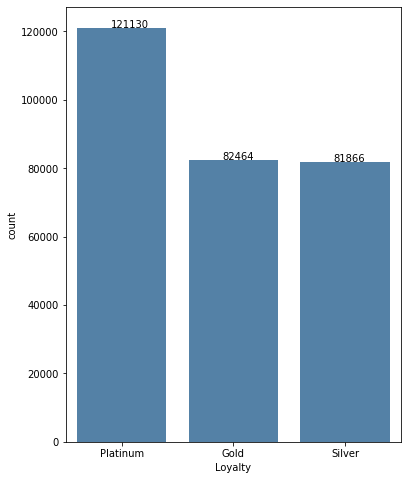

In [21]:
# inspect our loyalty segmentation

df_rfm_loyalty = rfm_loyalty.toPandas().sort_values(["RFM_ScoreGroup"])

fig, ax = plt.subplots(1, 1, figsize=(6, 8))

sns.countplot(x="Loyalty", data=df_rfm_loyalty, color='steelblue')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1))

In [21]:
# Restricting the dataset (Monetary < 5000 & Frequency < 500) to best fit the chart

df_rfm_loyalty = (rfm_loyalty
    .filter(F.col("Monetary") < 5000)
    .filter(F.col("Frequency") < 500)
).toPandas()

<AxesSubplot:xlabel='Monetary', ylabel='Frequency'>

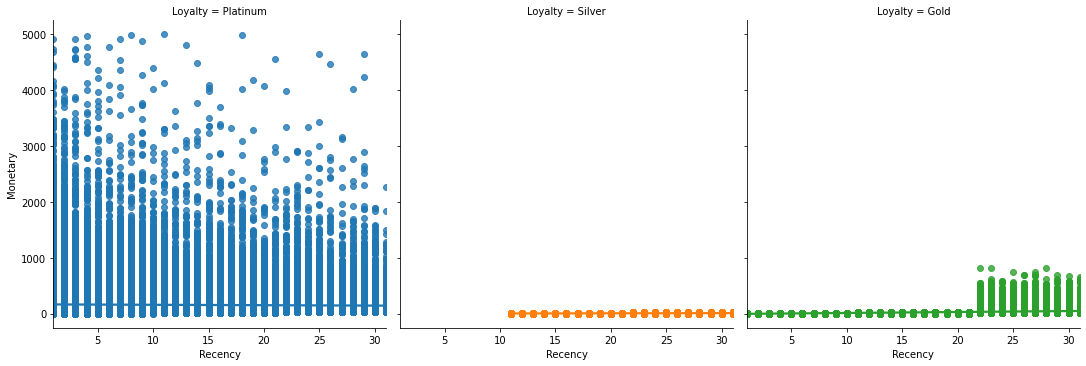

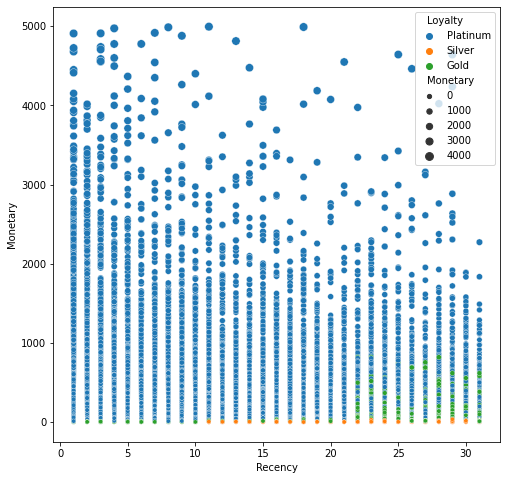

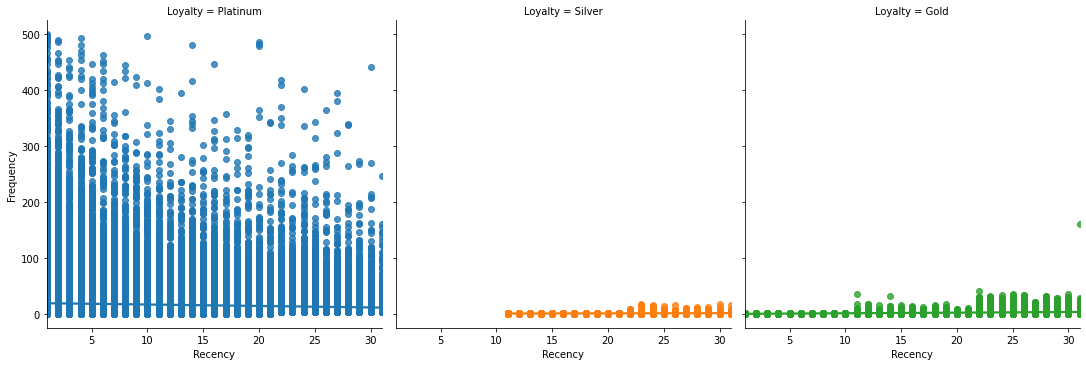

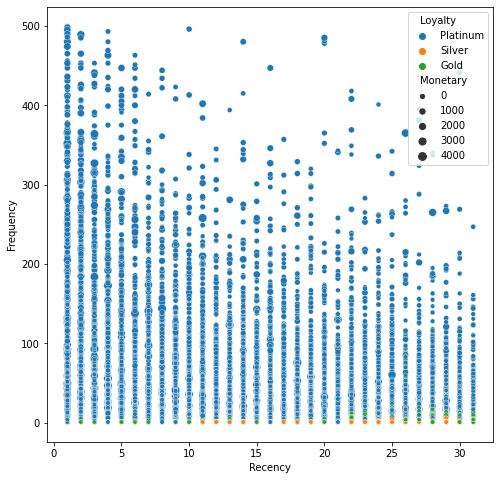

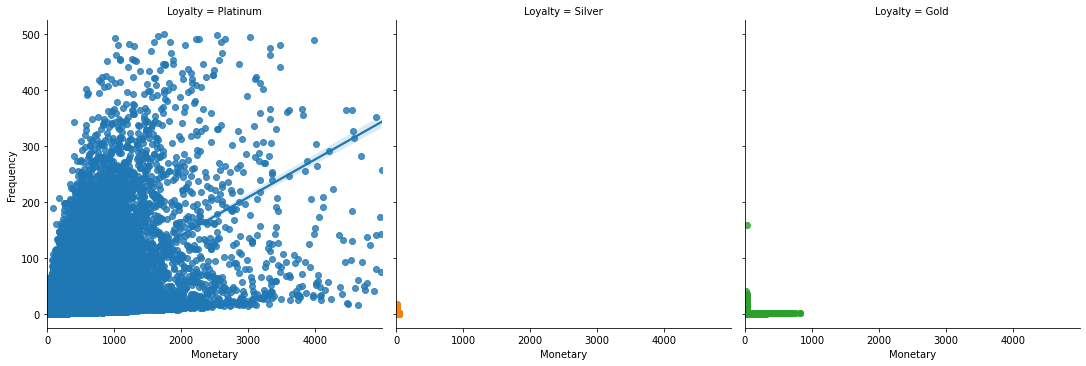

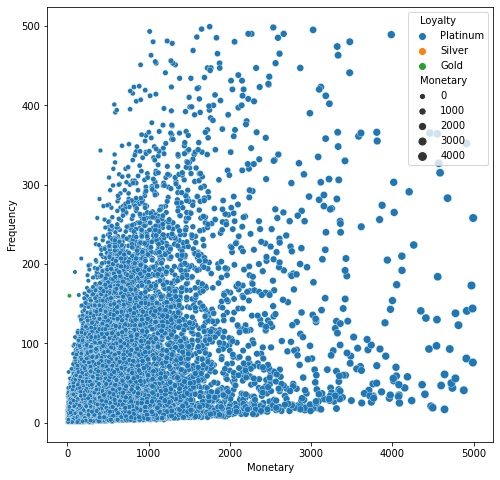

In [22]:
# Monetary vs Recency for each segment
sns.lmplot(x='Recency', y='Monetary', data=df_rfm_loyalty, col='Loyalty', hue='Loyalty', fit_reg=True)

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Monetary', data=df_rfm_loyalty, hue='Loyalty', size='Monetary')

# Frequency vs Recency for each segment
sns.lmplot(x='Recency', y='Frequency', data=df_rfm_loyalty, col='Loyalty', hue='Loyalty', fit_reg=True)

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Recency', y='Frequency', data=df_rfm_loyalty, hue='Loyalty', size='Monetary')

# Monetary vs Frequency for each segment
sns.lmplot(x='Monetary', y='Frequency', data=df_rfm_loyalty, col='Loyalty', hue='Loyalty', fit_reg=True)

# Monetary vs Frequency (combined)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x='Monetary', y='Frequency', data=df_rfm_loyalty, hue='Loyalty', size='Monetary')

In [23]:
# Assign loyalty level to each customer

# Champion: Loyal Customers, they are the champions with highest score of RFM.
# Potential: Customers who have the most potential to become the Champions.
#            They recently shopped and their purchases frequency is high as well. 
#            Moreover, the amount they spent is quite good.
# Require Attention: Customers who used to shop a lot with high money. but they did not purchase recently. 
# Lost: Customers who haven't paid a visit to the store for a long time.


segments = {
    'Champion':['111'], 
    'Potential':['112','113','121','131','123','122','133','132'], 
    'Need Attention':['211','221','231','232','213','212','233','223','222'],
    'Lost':['312','321','331','311','333','332','323','322','313']
}

rfm_segment = (rfm_agg_scores
    .withColumn("Segment",
                F.when((F.col("RFM_ScoreGroup").isin(segments['Champion'])), F.lit('Champion'))
                 .when((F.col("RFM_ScoreGroup").isin(segments['Potential'])), F.lit('Potential'))
                 .when((F.col("RFM_ScoreGroup").isin(segments['Need Attention'])), F.lit('Need Attention'))
                 .otherwise(F.lit('Lost'))))

In [24]:
rfm_segment.show()

+--------+-------+---------+------------------+-------+-------+-------+---------+--------------+--------------+
| user_id|Recency|Frequency|          Monetary|R_Score|F_Score|M_Score|RFM_Score|RFM_ScoreGroup|       Segment|
+--------+-------+---------+------------------+-------+-------+-------+---------+--------------+--------------+
| 4103071|     11|        5|             16.57|      2|      1|      2|        5|           212|Need Attention|
| 8846226|     30|       32|            140.19|      3|      1|      1|        5|           311|          Lost|
| 9794320|      9|       19|16.359999999999996|      1|      1|      2|        4|           112|     Potential|
|10280338|      5|       79| 418.7999999999998|      1|      1|      1|        3|           111|      Champion|
|12055855|     16|        2|              6.46|      2|      2|      3|        7|           223|Need Attention|
|13383118|     20|        1|              8.89|      2|      2|      3|        7|           223|Need Att

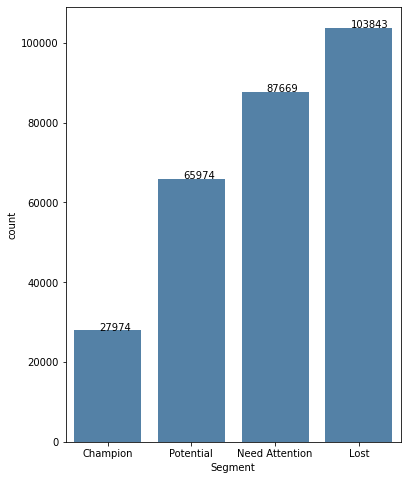

In [24]:
df_rfm_segment = rfm_segment.toPandas().sort_values(["RFM_ScoreGroup"])

fig, ax = plt.subplots(1, 1, figsize=(6, 8))

# sns.histplot(df_rfm_loyalty["Loyalty"], color='steelblue', shrink=.8)
sns.countplot(x="Segment", data=df_rfm_segment, color='steelblue')
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x() + 0.3, p.get_height() + 1))